In [1]:
import pandas as pd
import numpy as np

import os
print(os.getcwd())

/Users/vega7unk/Documents/4th Sem DSI/ilab project/ilab-group-12-1-fall-detection/notebooks


/Users/vega7unk/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_pickle("../data/df_filtered_cnn.pkl")

df.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
timestamp,,,,,,,
1970-01-01 00:38:38.700,0.209754,-2.331582,-0.203113,0.037081,0.031012,-0.012518,BSC
1970-01-01 00:38:38.800,0.203321,-2.349069,-0.194536,0.066225,0.079630,0.009396,BSC
1970-01-01 00:38:38.900,0.249716,-2.355785,-0.211275,0.196319,0.130287,0.033033,BSC
1970-01-01 00:38:39.000,0.276253,-2.345908,-0.201750,0.452604,0.035785,0.063763,BSC
1970-01-01 00:38:39.100,0.229522,-2.311028,-0.161954,0.682246,0.042157,0.127645,BSC


In [3]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(data, window_size=25, step_size=12):
    X, y = [], []
    data_array = data[sensor_cols].values
    labels = data['label'].values

    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window_data = data_array[start:end]
        window_labels = labels[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X.append(window_data)
        y.append(label)

    return np.array(X), np.array(y)

X, y = create_windows(df)

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Attention, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Assuming X_train is your training data with shape: (num_samples, window_length, num_channels)
# Example:
#    window_length = 25 (time steps)
#    num_channels = 6 (sensor channels)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(set(y_train))  # For instance, 16 classes if you have 16 distinct labels

# Input layer
inputs = Input(shape=input_shape)

# --- CNN Blocks ---
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)

# --- LSTM Layer ---
# return_sequences=True is important to preserve the temporal structure for the attention layer.
x = LSTM(64, return_sequences=True)(x)

# --- Self-Attention ---
# The Attention layer computes a weighted sum of the LSTM outputs.
# Using the same tensor for queries and keys/values implements self-attention.
attn_output = Attention()([x, x])
# Optionally, you can combine the attention output with the LSTM output.
# Here, we simply use the attention output further.
x = GlobalAveragePooling1D()(attn_output)

# --- Dense Layers for Classification ---
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Build and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 25, 64)    │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 25, 128)   │     24,704 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 12, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 128)   │     49,280 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     49,408 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 12, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 129,808 (507.06 KB)

 Trainable params: 129,808 (507.06 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7406 - loss: 0.8417 - val_accuracy: 0.8979 - val_loss: 0.2731
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8948 - loss: 0.2928 - val_accuracy: 0.9229 - val_loss: 0.2075
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9138 - loss: 0.2288 - val_accuracy: 0.9263 - val_loss: 0.1885
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9230 - loss: 0.1937 - val_accuracy: 0.9319 - val_loss: 0.1690
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9283 - loss: 0.1727 - val_accuracy: 0.9388 - val_loss: 0.1555
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9354 - loss: 0.1549 - val_accuracy: 0.9444 - val_loss: 0.1351
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9415 - loss: 0.1401 - val_accuracy: 0.9469 - val_loss: 0.1336
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9466 - loss: 0

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9725 - loss: 0.0674 - val_accuracy: 0.9608 - val_loss: 0.1322


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.1322
Test Accuracy: 0.9608
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


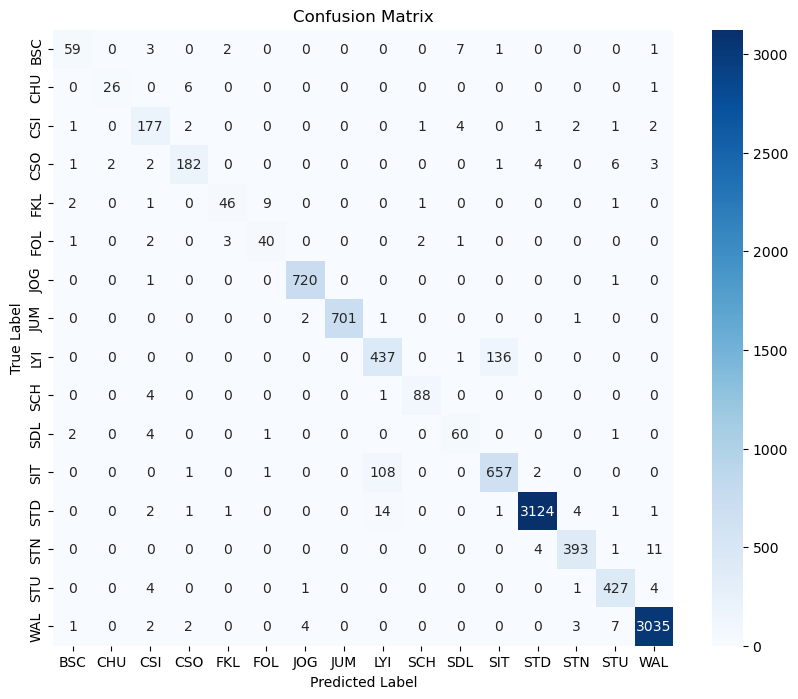

Classification Report:
               precision    recall  f1-score   support

         BSC       0.88      0.81      0.84        73
         CHU       0.93      0.79      0.85        33
         CSI       0.88      0.93      0.90       191
         CSO       0.94      0.91      0.92       201
         FKL       0.88      0.77      0.82        60
         FOL       0.78      0.82      0.80        49
         JOG       0.99      1.00      0.99       722
         JUM       1.00      0.99      1.00       705
         LYI       0.78      0.76      0.77       574
         SCH       0.96      0.95      0.95        93
         SDL       0.82      0.88      0.85        68
         SIT       0.83      0.85      0.84       769
         STD       1.00      0.99      0.99      3149
         STN       0.97      0.96      0.97       409
         STU       0.96      0.98      0.97       437
         WAL       0.99      0.99      0.99      3054

    accuracy                           0.96     10587
  

In [9]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]

metrics = evaluate_model(model, X_test, y_test, label_classes=label_classes)
